# Data Analytics

We seek to analyse the format of the input dataset, of the SQL queries at hand and obviously determine causalities between input queries and execution time.

## Part 0: Imports

In [1]:
import pandas as pd

## Part 1: Exploring the datasets

In this notebook Pandas will be adopted as a data exploration tool.

In [2]:
general_log_df = pd.read_json("data/general_log.json")
slow_log_df = pd.read_json("data/slow_log.json")

In [3]:
general_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16101 entries, 0 to 16100
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_time    16101 non-null  datetime64[ns]
 1   user_host     16101 non-null  object        
 2   thread_id     16101 non-null  int64         
 3   server_id     16101 non-null  int64         
 4   command_type  16101 non-null  object        
 5   argument      16101 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 754.9+ KB


In [4]:
slow_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15688 entries, 0 to 15687
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_time      15688 non-null  datetime64[ns]
 1   user_host       15688 non-null  object        
 2   query_time      15688 non-null  datetime64[ns]
 3   lock_time       15688 non-null  datetime64[ns]
 4   rows_sent       15688 non-null  int64         
 5   rows_examined   15688 non-null  int64         
 6   db              15688 non-null  object        
 7   last_insert_id  15688 non-null  int64         
 8   insert_id       15688 non-null  int64         
 9   server_id       15688 non-null  int64         
 10  sql_text        15688 non-null  object        
 11  thread_id       15688 non-null  int64         
dtypes: datetime64[ns](3), int64(6), object(3)
memory usage: 1.4+ MB


The two dataframes have different schemas: slow_log_df also contains some information about the database lock time, the number of rows that have been somehow manipulated and other debugging information. The semantically common columns still have different names (e.g. event_time vs start_time/query_time).

Let us have a look on the statistics of numerical columns for slow_log_df.

To satisfy our curiosity, let us see which values appear in the `db` and `*_id` columns.

In [5]:
print(slow_log_df["db"].unique())
print(slow_log_df["server_id"].unique())
print(slow_log_df["thread_id"].unique())
print(slow_log_df["insert_id"].unique())
print(slow_log_df["last_insert_id"].unique())

['tpch' '']
[97408076]
[67  9 66 65 63 64 62 61 60 59 58 57 40 56 55 54 53 52 51 50 49 48 47 46
 45 44 43 42 41 39 38 37 36 35 34 33 20 32 31 30 29 28 27 26 25 24 23 22
 21 19 18 14]
[0]
[0]


As it turns out, the records above are not quite useful. We thus drop them and consider the following:

- `query_time`
- `lock_time`
- `rows_sent`
- `rows_examined`
- `sql_text`

In [6]:
slow_log_df["query_time"].dt.microsecond

0            93
1            55
2            76
3           138
4            90
          ...  
15683        74
15684       147
15685        91
15686       102
15687    181089
Name: query_time, Length: 15688, dtype: int64

In [7]:
numerical_cols = ["query_time", "lock_time", "rows_sent",
                  "rows_examined", "sql_text"]

# convert datetime64 into int
slow_log_numerical_df = slow_log_df[numerical_cols]
slow_log_numerical_df["query_time_int"] = slow_log_numerical_df["query_time"].dt.microsecond
slow_log_numerical_df["lock_time_int"] = slow_log_numerical_df["lock_time"].dt.microsecond
slow_log_numerical_df = slow_log_numerical_df.drop(["query_time", "lock_time"], axis=1)

slow_log_numerical_df.describe(datetime_is_numeric=True)

<ipython-input-7-31917f1af7f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slow_log_numerical_df["query_time_int"] = slow_log_numerical_df["query_time"].dt.microsecond
<ipython-input-7-31917f1af7f2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slow_log_numerical_df["lock_time_int"] = slow_log_numerical_df["lock_time"].dt.microsecond


,rows_sent,rows_examined,query_time_int,lock_time_int
count,15688.000000,1.568800e+04,15688.000000,15688.000000
mean,8554.359574,6.093278e+05,144810.271800,155.016382
std,32730.257214,1.253887e+06,232662.161443,931.420305
min,0.000000,0.000000e+00,7.000000,0.000000
25%,1.000000,1.000000e+00,442.000000,0.000000
50%,1.000000,1.000000e+00,1299.500000,72.000000
75%,31.250000,3.415950e+05,227597.750000,177.000000
max,241191.000000,4.501838e+06,999952.000000,71033.000000


A lot can be said right now:
    
- There is a wild excursion in rows_sent: the minimum is 0, the maximum is 241191, the standard deviation is roughly 32,000. Similar numbers apply to rows_examined
- query time ranges from 7 microseconds to 999952 microseconds, i.e. almost an entire second.
- These times are heavily unbalanced: for what concerns query_time_int the 25% percentile is just 442 us, the 50% is barely 13000 us (13 ms), the 75% 228 ms.
- Lock time seems less useful as it seems "small" (in the order of a few microseconds) for the 75% percentile, but has an outlier of 71 ms.

A good guess is that the huge loading times are due to many rows being manipulated (this still _ignores_ the causes for that). In a few cells, we will prove this hypothesis.

A plot will be more convincing

(array([1.5401e+04, 2.2100e+02, 1.3000e+01, 5.0000e+00, 3.0000e+00,
        2.0000e+00, 4.0000e+00, 1.0000e+00, 8.0000e+00, 2.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 7.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

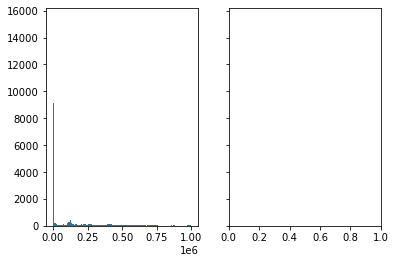

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# make a histogram on bucketised frequency

fig, axs = plt.subplots(1, 2, sharey=True)
# bins = np.linspace(0, 1_000_000)
axs[0].hist(slow_log_numerical_df["query_time_int"], bins=100)
axs[0].hist(slow_log_numerical_df["lock_time_int"], bins=100)

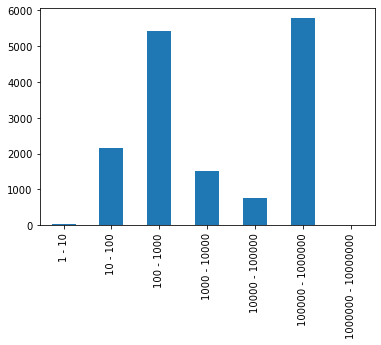

In [9]:
# the plots above are unreadable! let us show a log plot.

def make_log_plot(series, base=10):
    exp = int(np.ceil(np.log(series.max()) / np.log(base)))
    bins=[int(x) for x in np.geomspace(1, base**(exp+1), exp+2)]

    labels = ["{} - {}".format(left, left*base) for left in bins]
    log_freqs = pd.cut(series, bins, labels=labels[:-1]).value_counts()

    log_freqs.sort_index().plot(kind="bar")

make_log_plot(slow_log_numerical_df["query_time_int"])

The time distribution shows two peaks: the times between 100 us and 1ms, and the times 100,000 us and 1,000,000 us (100 ms and 1s, respectively). Quite obviously, the data does not look sampled from a normal distribution.

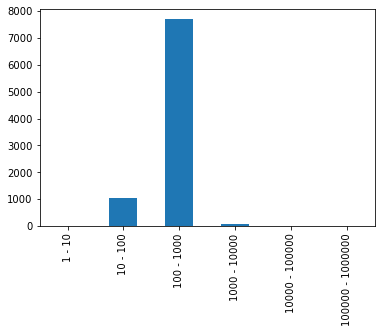

In [10]:
make_log_plot(slow_log_numerical_df["lock_time_int"], base=10)

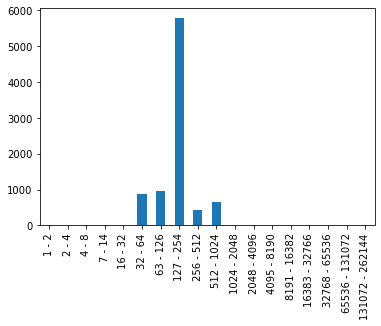

In [11]:
# More granular
make_log_plot(slow_log_numerical_df["lock_time_int"], base=2)

We confirm the suspect nurtured above about `lock_time`: the times seem centered around 254 us. The distribution is normal-like with relatively short tails, as to be expected.

In [12]:
log_numerical_df = slow_log_numerical_df.drop(["lock_time_int"], axis=1)
log_numerical_df.describe()

,rows_sent,rows_examined,query_time_int
count,15688.000000,1.568800e+04,15688.000000
mean,8554.359574,6.093278e+05,144810.271800
std,32730.257214,1.253887e+06,232662.161443
min,0.000000,0.000000e+00,7.000000
25%,1.000000,1.000000e+00,442.000000
50%,1.000000,1.000000e+00,1299.500000
75%,31.250000,3.415950e+05,227597.750000
max,241191.000000,4.501838e+06,999952.000000


Let us use Pearson's Correlation test to determine how much `rows_examined` and `query_time_int` are used.

In [15]:
import scipy.stats

scipy.stats.pearsonr(log_numerical_df["rows_examined"], log_numerical_df["query_time_int"])

(0.5968870258290725, 0.0)

The correlation seems existing, although not fully linear.

## Part 2: SQL query format

We can now inspect the big elephant in the room: the SQL queries.

In [21]:
sql_text = log_numerical_df["sql_text"]

sql_text.head(50)

0     /* ApplicationName=DataGrip 2020.2.3 */ SET ne...
1                                         SHOW WARNINGS
2                                         SHOW WARNINGS
3     /* ApplicationName=DataGrip 2020.2.3 */ select...
4     /* ApplicationName=DataGrip 2020.2.3 */ SET SQ...
5                                         SHOW WARNINGS
6                SELECT @@session.transaction_read_only
7     /* ApplicationName=DataGrip 2020.2.3 */ set se...
8                SELECT @@session.transaction_isolation
9                                                  Ping
10                                                 Ping
11                                                 Ping
12                            SELECT @@GLOBAL.read_only
13                                             SELECT 1
14               SELECT value FROM mysql.rds_heartbeat2
15                                             SELECT 1
16    SELECT count(*) from information_schema.TABLES...
17                                             S

In [74]:
# strip comments
log_numerical_df["sql_cleaned"] = sql_text \
        .str.replace(r"/\*.*?\*/", '') \
        .str.replace(r"--[^\n\t]+", '') \
        .str.replace(r"(\n|\t)", " ") \
        .str.strip()

<ipython-input-74-4546809bf898>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  log_numerical_df["sql_cleaned"] = sql_text \


In [75]:
log_numerical_df["sql_cleaned"]

0                                    SET net_write_timeout=600
1                                                SHOW WARNINGS
2                                                SHOW WARNINGS
3                                            select database()
4                                 SET SQL_SELECT_LIMIT=DEFAULT
                                 ...                          
15683                                                 SELECT 1
15684                                                 SELECT 1
15685                   SELECT @@session.transaction_isolation
15686                                            SHOW WARNINGS
15687    select * from mysql.slow_log order by start_time desc
Name: sql_cleaned, Length: 15688, dtype: object

select        15262
show             92
flush            48
quit             47
purge            46
commit           44
insert           44
statistics       44
set              42
ping             16
use               3
Name: sql_category, dtype: int64


<AxesSubplot:>

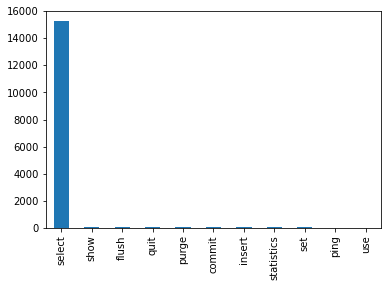

In [76]:
# Inspect the queries by category

log_numerical_df["sql_category"] = log_numerical_df["sql_cleaned"] \
    .str.split(' ') \
    .str[0] \
    .str.lower()
sql_categories_freqs = log_numerical_df["sql_category"].value_counts()
print(sql_categories_freqs)

sql_categories_freqs.plot(kind="bar")

Let us peak at the top 5 worst performing queries

In [80]:
top_5 = log_numerical_df.sort_values(by="query_time_int").tail(5)[["sql_cleaned", "query_time_int", "rows_examined", "rows_sent"]]

top_5

,sql_cleaned,query_time_int,rows_examined,rows_sent
11019,"select l_returnflag, l_linestatus, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '93' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",999514,4423667,4
15097,"select l_returnflag, l_linestatus, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '106' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",999798,4423667,4
6066,"select o_year, sum(case when nation = 'MOZAMBIQUE' then volume else 0 end) / sum(volume) as mkt_share from ( select extract(year from o_orderdate) as o_year, l_extendedprice * (1 - l_discount) as volume, n2.n_name as nation from part, supplier, lineitem, orders, customer, nation n1, nation n2, region where p_partkey = l_partkey and s_suppkey = l_suppkey and l_orderkey = o_orderkey and o_custkey = c_custkey and c_nationkey = n1.n_nationkey and n1.n_regionkey = r_regionkey and r_name = 'AFRICA' and s_nationkey = n2.n_nationkey and o_orderdate between date '1995-01-01' and date '1996-12-31' and p_type = 'MEDIUM BURNISHED BRASS' ) as all_nations group by o_year order by o_year",999806,4157561,2
14778,"select c_custkey, c_name, c_acctbal, n_name, c_address, c_phone, c_comment from customer, orders, lineitem, nation where c_custkey = o_custkey and l_orderkey = o_orderkey and o_orderdate >= date '1994-09-01' and o_orderdate < date '1994-09-01' + interval '3' month and l_returnflag = 'R' and c_nationkey = n_nationkey",999842,1952974,113162
11629,"select l_returnflag, l_linestatus, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '120' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",999952,4423667,4


In [78]:
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

Interesting bit, all of these queries are `SELECT` queries.

The first one above, at index 11019, inspects the status for orders antecedent to 93 days before the 12th of January, 1998, then groups and orders by return flag and line status.

```SQL
select l_returnflag, l_linestatus, count(*) as count_order
from lineitem
where l_shipdate <= date '1998-12-01' - interval '93' day
group by l_returnflag, l_linestatus
order by l_returnflag, l_linestatus
```

The second and fifth query are similar but change the interval period to 106 and 120 days, respectively.


The third query is the most complex as it involves a _subquery_:

```SQL
select o_year, sum(case when nation = 'MOZAMBIQUE' then volume else 0 end) / sum(volume) as mkt_share
from (
    select extract(year from o_orderdate) as o_year, l_extendedprice * (1 - l_discount) as volume, n2.n_name as nation
    from part, supplier, lineitem, orders, customer, nation n1, nation n2, region
    where
        -- NxM relation join
        p_partkey = l_partke
        and s_suppkey = l_suppkey
        and l_orderkey = o_orderkey
        and o_custkey = c_custkey
        and c_nationkey = n1.n_nationkey 
        and n1.n_regionkey = r_regionkey
        and r_name = 'AFRICA'
        and s_nationkey = n2.n_nationkey
        and o_orderdate between date '1995-01-01' and date '1996-12-31'
        and p_type = 'MEDIUM BURNISHED BRASS'
) as all_nations
group by o_year
order by o_year
```

This query measures the market share of Mozambique buyers ordering medium burnished brass parts bewteen 1st January 1995 and 31st December 1996 (i.e. a 2-year span) within the African Market.

The last interesting query is the fourth:

```SQL
select c_custkey, c_name, c_acctbal, n_name, c_address, c_phone, c_comment
from customer, orders, lineitem, nation
where c_custkey = o_custkey and l_orderkey = o_orderkey and o_orderdate >= date '1994-09-01' and o_orderdate < date '1994-09-01' + interval '3' month and l_returnflag = 'R' and c_nationkey = n_nationkey
```

The `rows_examined` column shows that each of these queries required many rows to be iterated. In all the previous queries we needed to select time ranges. This leads us to believe the `o_orderdate` column is probably not indexed. As a consequence, InnoDB does not perform range query optimisations for date retrieval, therefore a simple range check requires an overall $\mathcal{O}(n)$ complexity.

The discrepancy between `rows_examined` and `rows_sent` is a strong indicator of a missing index. Indeed, the DDL file shows no index has been applied to any date column. We seek to find *other* possible causes we are not taking into account.

In [81]:
top_10 = log_numerical_df.sort_values(by="query_time_int").tail(10)[["sql_cleaned", "query_time_int", "rows_examined", "rows_sent"]]

top_10

,sql_cleaned,query_time_int,rows_examined,rows_sent
8035,"select s_name, count(*) as numwait from supplier, lineitem l1, orders, nation where s_suppkey = l1.l_suppkey and o_orderkey = l1.l_orderkey and o_orderstatus = 'F' and l1.l_receiptdate > l1.l_commitdate and exists ( select * from lineitem l2 where l2.l_orderkey = l1.l_orderkey and l2.l_suppkey <> l1.l_suppkey ) and not exists ( select * from lineitem l3 where l3.l_orderkey = l1.l_orderkey and l3.l_suppkey <> l1.l_suppkey and l3.l_receiptdate > l3.l_commitdate ) and s_nationkey = n_nationkey and n_name = 'RUSSIA' group by s_name order by numwait desc, s_name",997401,403374,407
7639,"select nation, o_year, sum(amount) as sum_profit from ( select n_name as nation, extract(year from o_orderdate) as o_year, l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity as amount from part, supplier, lineitem, partsupp, orders, nation where s_suppkey = l_suppkey and ps_suppkey = l_suppkey and ps_partkey = l_partkey and p_partkey = l_partkey and o_orderkey = l_orderkey and s_nationkey = n_nationkey and p_name like '%khaki%' ) as profit group by nation, o_year order by nation, o_year desc",997594,1372470,150
11433,"select l_returnflag, l_linestatus, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '96' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",998741,4423667,4
4842,"select s_name, count(*) as numwait from supplier, lineitem l1, orders, nation where s_suppkey = l1.l_suppkey and o_orderkey = l1.l_orderkey and o_orderstatus = 'F' and l1.l_receiptdate > l1.l_commitdate and exists ( select * from lineitem l2 where l2.l_orderkey = l1.l_orderkey and l2.l_suppkey <> l1.l_suppkey ) and not exists ( select * from lineitem l3 where l3.l_orderkey = l1.l_orderkey and l3.l_suppkey <> l1.l_suppkey and l3.l_receiptdate > l3.l_commitdate ) and s_nationkey = n_nationkey and n_name = 'BRAZIL' group by s_name order by numwait desc, s_name",998742,386320,388
15006,"select o_year, case when nation = 'JORDAN' then volume else 0 end from ( select extract(year from o_orderdate) as o_year, l_extendedprice * (1 - l_discount) as volume, n2.n_name as nation from part, supplier, lineitem, orders, customer, nation n1, nation n2, region where p_partkey = l_partkey and s_suppkey = l_suppkey and l_orderkey = o_orderkey and o_custkey = c_custkey and c_nationkey = n1.n_nationkey and n1.n_regionkey = r_regionkey and r_name = 'MIDDLE EAST' and s_nationkey = n2.n_nationkey and o_orderdate between date '1995-01-01' and date '1996-12-31' and p_type = 'PROMO BRUSHED STEEL' ) as all_nations",999140,1427931,2022
11019,"select l_returnflag, l_linestatus, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '93' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",999514,4423667,4
15097,"select l_returnflag, l_linestatus, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '106' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",999798,4423667,4
6066,"select o_year, sum(case when nation = 'MOZAMBIQUE' then volume else 0 end) / sum(volume) as mkt_share from ( select extract(year from o_orderdate) as o_year, l_extendedprice * (1 - l_discount) as volume, n2.n_name as nation from part, supplier, lineitem, orders, customer, nation n1, nation n2, region where p_partkey = l_partkey and s_suppkey = l_suppkey and l_orderkey = o_orderkey and o_custkey = c_custkey and c_nationkey = n1.n_nationkey and n1.n_regionkey = r_regionkey and r_name = 'AFRICA' and s_nationkey = n2.n_nationkey and o_orderdate between date '1995-01-01' and date '1996-12-31' and p_type = 'MEDIUM BURNISHED BRASS' ) as all_nations group by o_year order by o_year",999806,4157561,2
14778,"select c_custkey, c_name, c_acctbal, n_name, c_address, c_phone, c_comment from customer, orders, lineitem, nation where c_custkey = o_custkey and l_orderkey = o_orderkey and o_orderdate >= da

```SQL
select s_name, count(*) as numwait
from supplier, lineitem l1, orders, nation

where
    s_suppkey = l1.l_suppkey
    and o_orderkey = l1.l_orderkey
    and o_orderstatus = 'F'
    and l1.l_receiptdate > l1.l_commitdate
    and exists (
        select *
        from lineitem l2
        where
            l2.l_orderkey = l1.l_orderkey
            and l2.l_suppkey <> l1.l_suppkey
    ) and not exists (
        select * from lineitem l3
        where l3.l_orderkey = l1.l_orderkey
            and l3.l_suppkey <> l1.l_suppkey
            and l3.l_receiptdate > l3.l_commitdate
    ) and s_nationkey = n_nationkey
      and n_name = 'RUSSIA'
    group by s_name
    order by numwait desc, s_name
```

Which shows a number of failed orders from russian supplier vendors. Even here, a date comparison is performed. An interesting 